In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from gensim.models import Word2Vec
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random

# load dataset

In [2]:
# Load dataset
books = pd.read_csv('final_dataset_V3.csv')
books = pd.DataFrame(books, columns=['title', 'genre', 'summary'])


In [3]:
books

,title,genre,summary
0,Going Wrong,crime,"When he was a young man, Guy Curran led a loc..."
1,The Screwtape Letters,fantasy,"In The Screwtape Letters, C.S. Lewis provides..."
2,King of Foxes,fantasy,"An exceptionally skilled swordsman, young Tal..."
3,If You Could See Me Now,horror,"The novel tells the story of Miles Teagarden,..."
4,Shatter Me,romance,I have a curse\nI have a gift\n\nI am a monste...
...,...,...,...
4995,Soldier's Heart,history,"(Conflict, Rising Action, Climax, Falling Act..."
4996,The Gifts of Imperfection,psychology,In this groundbreaking New York Times best sel...
4997,Talking to Strangers: What We Should Know Abou...,psychology,"Malcolm Gladwell, host of the podcast Revision..."
4998,Why We Sleep: Unlocking the Power of Sleep and...,psychology,Alternate cover edition of ISBN 9781501144318....


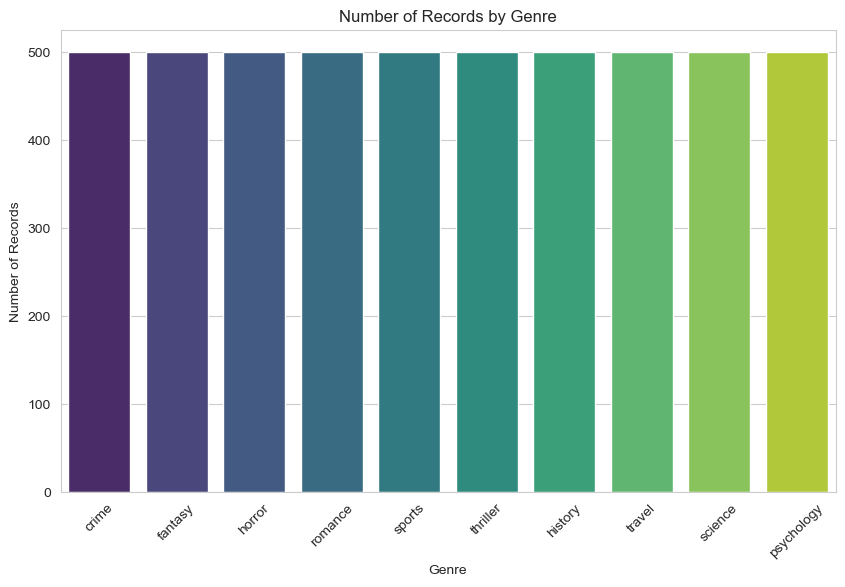

In [4]:
# Convert the dataset into a DataFrame
books = pd.DataFrame(books)

# Count the number of records for each genre
genre_counts = books['genre'].value_counts()

# Plotting
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xlabel("Genre")
plt.ylabel("Number of Records")
plt.title("Number of Records by Genre")
plt.xticks(rotation=45)
plt.show()


# words Frequency Visualization

most common used words in summry.




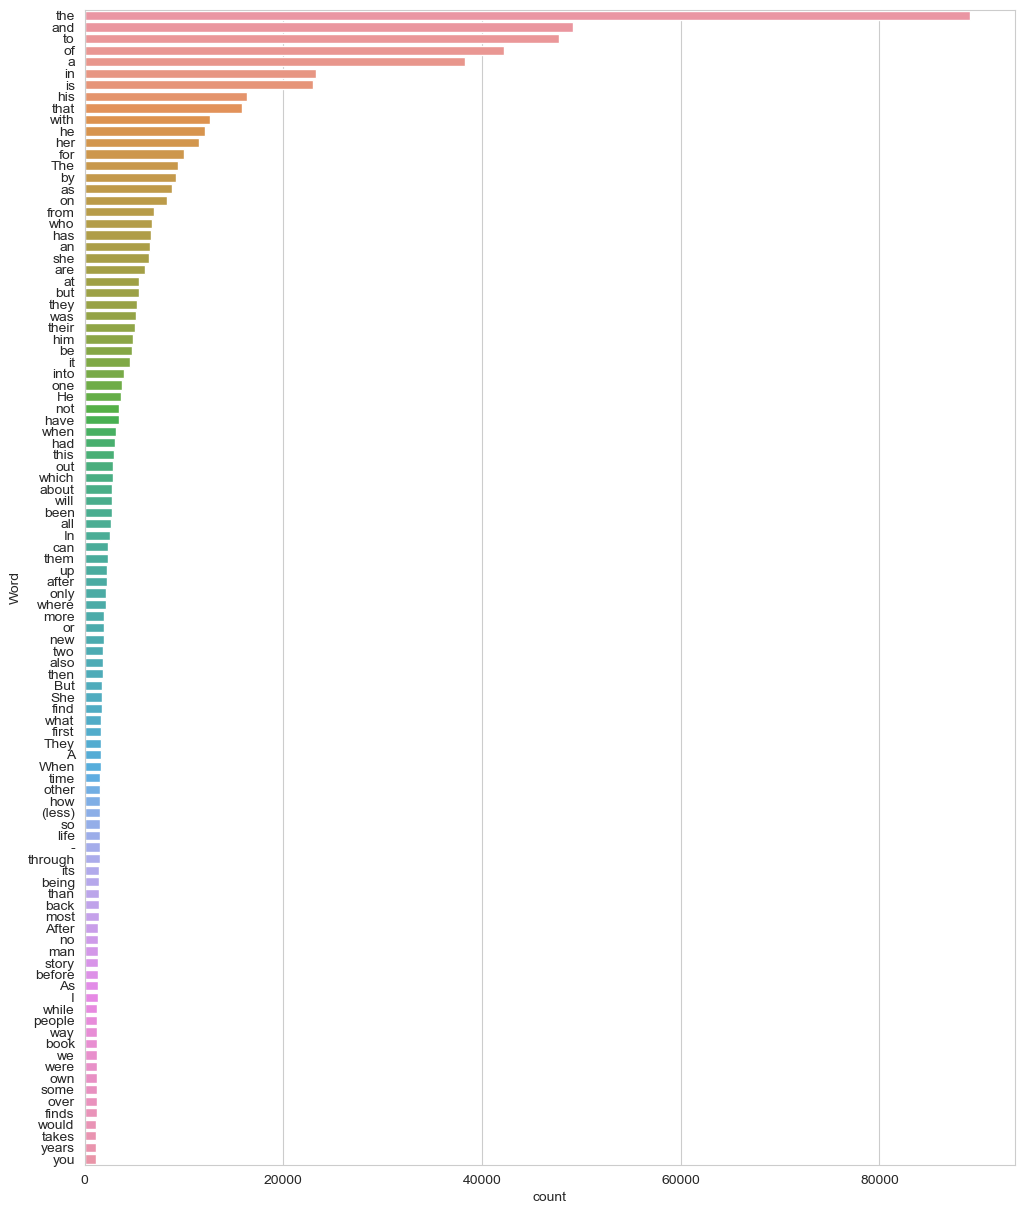

In [5]:
def freqwords(x, terms): 
    print("most common used words in summry.\n\n")
    allwords = ' '.join([text for text in x]) 
    allwords = allwords.split() 
    fdist = nltk.FreqDist(allwords) 
    wordsdf = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    d = wordsdf.nlargest(columns="count", n = terms)  
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

freqwords(books['summary'], 100)

# data preprocessing


## text cleaning

In [6]:
def clean(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

books.loc[:,'summary']=books.loc[:,'summary'].apply(lambda x: clean(x))

In [7]:
books

,title,genre,summary
0,Going Wrong,crime,when he was a young man guy curran led a local...
1,The Screwtape Letters,fantasy,in the screwtape letters c s lewis provides a ...
2,King of Foxes,fantasy,an exceptionally skilled swordsman young tal h...
3,If You Could See Me Now,horror,the novel tells the story of miles teagarden a...
4,Shatter Me,romance,i have a curse i have a gift i am a monster im...
...,...,...,...
4995,Soldier's Heart,history,conflict rising action climax falling action a...
4996,The Gifts of Imperfection,psychology,in this groundbreaking new york times best sel...
4997,Talking to Strangers: What We Should Know Abou...,psychology,malcolm gladwell host of the podcast revisioni...
4998,Why We Sleep: Unlocking the Power of Sleep and...,psychology,alternate cover edition of isbn neuroscientist...


## cleaning

In [8]:
# removing stop words from the text
def removestopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
    re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
    no_stopword_text = re_stop_words.sub(" ", text)
    return no_stopword_text

books['summary'] = books['summary'].apply(lambda x: removestopwords(x))

In [9]:
books

,title,genre,summary
0,Going Wrong,crime,young man guy curran led local street gan...
1,The Screwtape Letters,fantasy,screwtape letters c lewis provides series ...
2,King of Foxes,fantasy,exceptionally skilled swordsman young tal haw...
3,If You Could See Me Now,horror,novel tells story miles teagarden widowed ...
4,Shatter Me,romance,curse gift monster im human touch ...
...,...,...,...
4995,Soldier's Heart,history,conflict rising action climax falling action ...
4996,The Gifts of Imperfection,psychology,groundbreaking new york times best seller dr...
4997,Talking to Strangers: What We Should Know Abou...,psychology,malcolm gladwell host podcast revisionist hi...
4998,Why We Sleep: Unlocking the Power of Sleep and...,psychology,alternate cover edition isbn neuroscientist ...


## word -> original 

In [10]:
#stem each word
stemmer = PorterStemmer()
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


books['summary'] = books['summary'].apply(lambda x: stemming(x))

In [11]:
books

,title,genre,summary
0,Going Wrong,crime,young man guy curran led local street gang dea...
1,The Screwtape Letters,fantasy,screwtap letter c lewi provid seri lesson impo...
2,King of Foxes,fantasy,except skill swordsman young tal hawkin surviv...
3,If You Could See Me Now,horror,novel tell stori mile teagarden widow english ...
4,Shatter Me,romance,curs gift monster im human touch lethal touch ...
...,...,...,...
4995,Soldier's Heart,history,conflict rise action climax fall action resolu...
4996,The Gifts of Imperfection,psychology,groundbreak new york time best seller dr bren ...
4997,Talking to Strangers: What We Should Know Abou...,psychology,malcolm gladwel host podcast revisionist histo...
4998,Why We Sleep: Unlocking the Power of Sleep and...,psychology,altern cover edit isbn neuroscientist sleep ex...


# Visualization after cleaning

most common used words in summry.




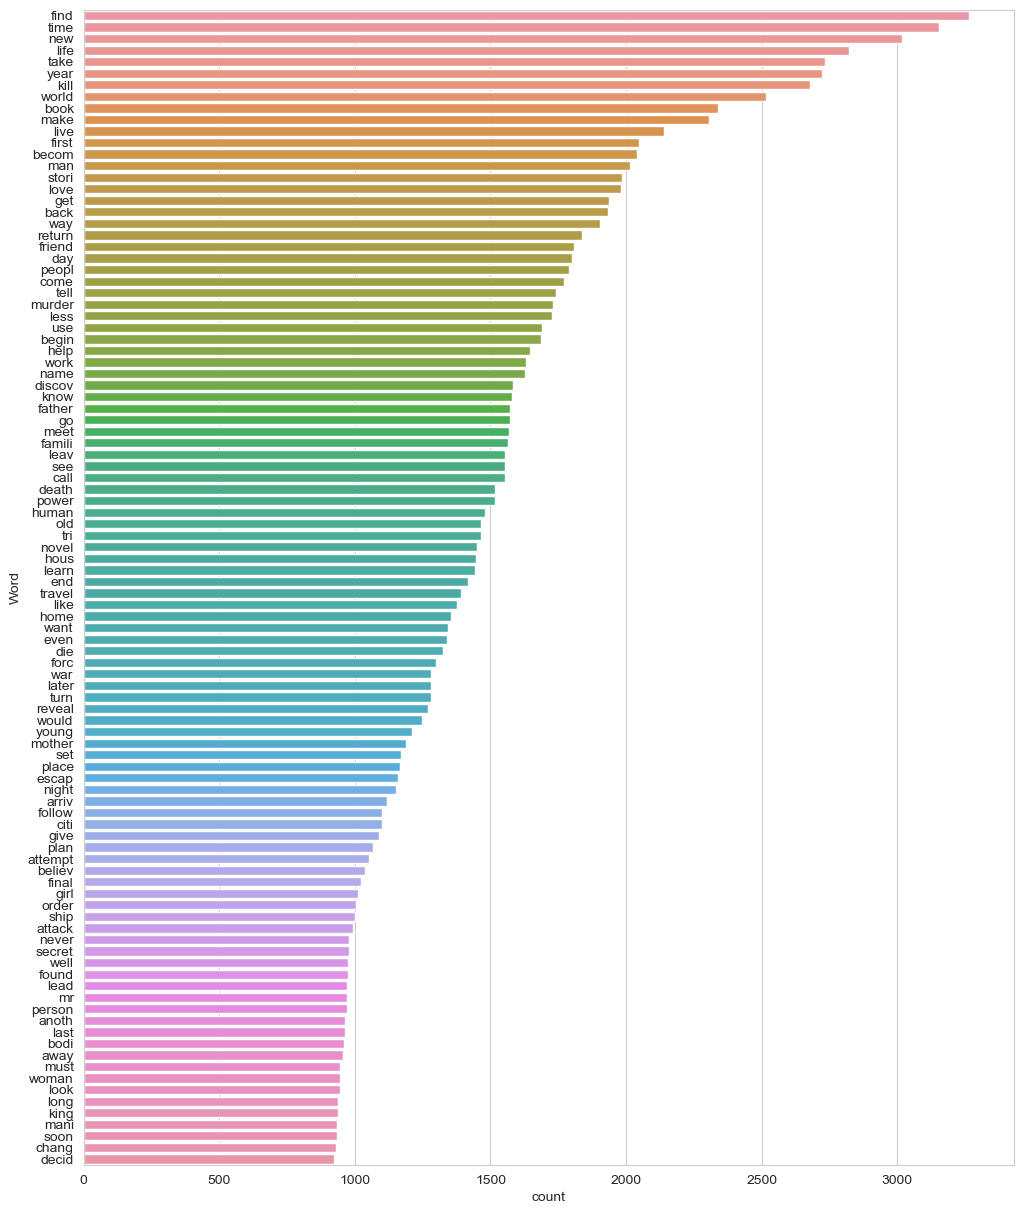

In [12]:
freqwords(books['summary'], 100)

# label encoding

In [13]:
# Encoding labels
LE = LabelEncoder()
y = LE.fit_transform(books['genre'])

In [14]:
#getting the labels number 
unique_labels = np.unique(y)
print(unique_labels)

[0 1 2 3 4 5 6 7 8 9]


In [15]:
LE.inverse_transform([0,1,2,3,4,5,6,7,8,9])

array(['crime', 'fantasy', 'history', 'horror', 'psychology', 'romance',
       'science', 'sports', 'thriller', 'travel'], dtype=object)

# Tokenization

## word -> number

In [16]:
# Tokenization and Vectorization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(books['summary'])
X = tokenizer.texts_to_sequences(books['summary'])
X = pad_sequences(X, maxlen=500)

In [17]:
# Load Word2Vec model
model_skipgram = Word2Vec.load("word2vec_SKIP.model")

# Initialize embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in model_skipgram.wv:
        embedding_matrix[i] = model_skipgram.wv[word]


# spliting

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# CNN Model

In [19]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM
from tensorflow.keras import regularizers

#model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=500, trainable=False))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(LE.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())


history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          3288400   
                                                                 
 conv1d (Conv1D)             (None, 496, 256)          128256    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                      

# learning curve

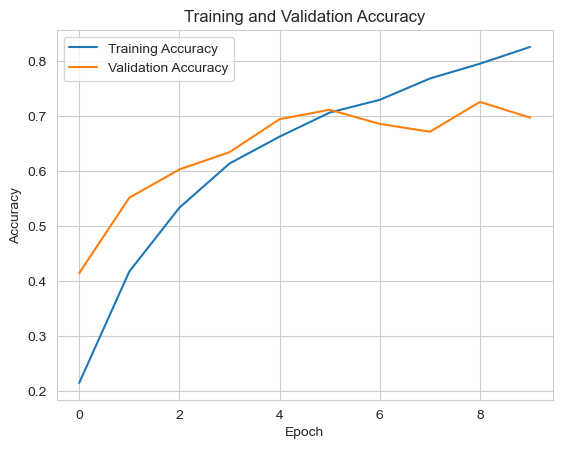

In [20]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# test the model

## prediction 

In [21]:
# Function to predict genre for a given summary
def predict_genre(summary):
    summary_sequence = tokenizer.texts_to_sequences([summary])
    summary_sequence = pad_sequences(summary_sequence, maxlen=500)  # Assuming max_sequence_length is 200
    predicted_probs = model.predict(summary_sequence)[0]
    predicted_genre_index = np.argmax(predicted_probs)
    predicted_genre = LE.inverse_transform([predicted_genre_index])[0]
    return predicted_genre


## output prediction

In [22]:
# Variables to count correct and incorrect predictions
correct_predictions = 0
incorrect_predictions = 0

for _ in range(500):  
    idx = random.randint(0, len(X_test) - 1)
    title = books['title'].iloc[idx]
    summary = books['summary'].iloc[idx]
    predicted_genre = predict_genre(summary)
    actual_genre = books['genre'].iloc[idx]
    
    print("\nBook:", title)
    print("Predicted Genre:", predicted_genre)
    print("Actual Genre:", actual_genre)
    
    # Check if prediction is correct
    if predicted_genre == actual_genre:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

# Print counts of correct and incorrect predictions
print("\nNumber of Correct Predictions:", correct_predictions)
print("Number of Incorrect Predictions:", incorrect_predictions)

1/1 [==============================] - 0s 70ms/step

Book: The Caliph's House: A Year in Casablanca
Predicted Genre: travel
Actual Genre: travel
1/1 [==============================] - 0s 17ms/step

Book: Atlas Obscura: An Explorer's Guide to the World's Hidden Wonders
Predicted Genre: travel
Actual Genre: travel
1/1 [==============================] - 0s 15ms/step

Book: The Kingdom by the Sea
Predicted Genre: travel
Actual Genre: travel
1/1 [==============================] - 0s 14ms/step

Book: Halo: Ghosts of Onyx
Predicted Genre: science
Actual Genre: science
1/1 [==============================] - 0s 15ms/step

Book: Legendary
Predicted Genre: romance
Actual Genre: fantasy
1/1 [==============================] - 0s 15ms/step

Book: Garrett
Predicted Genre: sports
Actual Genre: sports
1/1 [==============================] - 0s 17ms/step

Book: Bloodline
Predicted Genre: thriller
Actual Genre: horror
1/1 [==============================] - 0s 16ms/step

Book: Star Trek: The Motion Picture

1/1 [==============================] - 0s 16ms/step

Book: There Shall Be No Darkness
Predicted Genre: horror
Actual Genre: horror
1/1 [==============================] - 0s 16ms/step

Book: Chosen
Predicted Genre: fantasy
Actual Genre: horror
1/1 [==============================] - 0s 15ms/step

Book: The Bell Jar
Predicted Genre: psychology
Actual Genre: psychology
1/1 [==============================] - 0s 15ms/step

Book: A Dedicated Man
Predicted Genre: crime
Actual Genre: crime
1/1 [==============================] - 0s 15ms/step

Book: See Jane Run
Predicted Genre: thriller
Actual Genre: thriller
1/1 [==============================] - 0s 15ms/step

Book: The Kingdom by the Sea
Predicted Genre: travel
Actual Genre: travel
1/1 [==============================] - 0s 15ms/step

Book: Crooked Zebra
Predicted Genre: sports
Actual Genre: crime
1/1 [==============================] - 0s 15ms/step

Book: Birds Without Wings
Predicted Genre: history
Actual Genre: history
1/1 [==================

1/1 [==============================] - 0s 17ms/step

Book: CHERUB: Mad Dogs
Predicted Genre: thriller
Actual Genre: thriller
1/1 [==============================] - 0s 16ms/step

Book: The Courage to Be Disliked: How to Free Yourself, Change your Life and Achieve Real Happiness
Predicted Genre: psychology
Actual Genre: psychology
1/1 [==============================] - 0s 16ms/step

Book: The Wreck of the Zanzibar
Predicted Genre: horror
Actual Genre: history
1/1 [==============================] - 0s 15ms/step

Book: Feeling Good: The New Mood Therapy
Predicted Genre: psychology
Actual Genre: psychology
1/1 [==============================] - 0s 15ms/step

Book: Memoirs of Hadrian
Predicted Genre: history
Actual Genre: history
1/1 [==============================] - 0s 15ms/step

Book: How the Mind Works
Predicted Genre: psychology
Actual Genre: psychology
1/1 [==============================] - 0s 14ms/step

Book: All the Bright Places
Predicted Genre: romance
Actual Genre: romance
1/1 [==

1/1 [==============================] - 0s 14ms/step

Book: One Day in December
Predicted Genre: romance
Actual Genre: romance
1/1 [==============================] - 0s 15ms/step

Book: Bag Limit
Predicted Genre: crime
Actual Genre: crime
1/1 [==============================] - 0s 14ms/step

Book: Genome: the Autobiography of a Species in 23 Chapters
Predicted Genre: psychology
Actual Genre: science
1/1 [==============================] - 0s 15ms/step

Book: It
Predicted Genre: thriller
Actual Genre: thriller
1/1 [==============================] - 0s 15ms/step

Book: Open
Predicted Genre: sports
Actual Genre: sports
1/1 [==============================] - 0s 15ms/step

Book: 1,000 Places to See Before You Die
Predicted Genre: thriller
Actual Genre: travel
1/1 [==============================] - 0s 15ms/step

Book: Summer of '49
Predicted Genre: sports
Actual Genre: sports
1/1 [==============================] - 0s 16ms/step

Book: Deep Work: Rules for Focused Success in a Distracted World
Pr

1/1 [==============================] - 0s 16ms/step

Book: Hands Down
Predicted Genre: sports
Actual Genre: sports
1/1 [==============================] - 0s 15ms/step

Book: The Wreck of the Zanzibar
Predicted Genre: horror
Actual Genre: history
1/1 [==============================] - 0s 15ms/step

Book: The 5 Love Languages: The Secret to Love that Lasts
Predicted Genre: psychology
Actual Genre: psychology
1/1 [==============================] - 0s 15ms/step

Book: Crocodile on the Sandbank
Predicted Genre: history
Actual Genre: history
1/1 [==============================] - 0s 14ms/step

Book: Persuader
Predicted Genre: thriller
Actual Genre: thriller
1/1 [==============================] - 0s 18ms/step

Book: One True Loves
Predicted Genre: romance
Actual Genre: romance
1/1 [==============================] - 0s 18ms/step

Book: Ordeal by Innocence
Predicted Genre: crime
Actual Genre: crime
1/1 [==============================] - 0s 16ms/step

Book: The Brain that Changes Itself: Stories

1/1 [==============================] - 0s 16ms/step

Book: Jock Row
Predicted Genre: sports
Actual Genre: sports
1/1 [==============================] - 0s 15ms/step

Book: The Goal
Predicted Genre: sports
Actual Genre: sports
1/1 [==============================] - 0s 15ms/step

Book: Castle of Wizardry
Predicted Genre: fantasy
Actual Genre: fantasy
1/1 [==============================] - 0s 15ms/step

Book: The Hot Shot
Predicted Genre: sports
Actual Genre: sports
1/1 [==============================] - 0s 16ms/step

Book: Into the Land of the Unicorns
Predicted Genre: fantasy
Actual Genre: fantasy
1/1 [==============================] - 0s 15ms/step

Book: Drome
Predicted Genre: travel
Actual Genre: fantasy
1/1 [==============================] - 0s 14ms/step

Book: The Talented Mr. Ripley
Predicted Genre: thriller
Actual Genre: thriller
1/1 [==============================] - 0s 15ms/step

Book: Unto a Good Land
Predicted Genre: history
Actual Genre: history
1/1 [=========================

1/1 [==============================] - 0s 16ms/step

Book: Of the City of the Saved...
Predicted Genre: science
Actual Genre: science

Number of Correct Predictions: 415
Number of Incorrect Predictions: 85


# visualization for the model

## Confusion Matrix


47/47 [==============================] - 0s 8ms/step


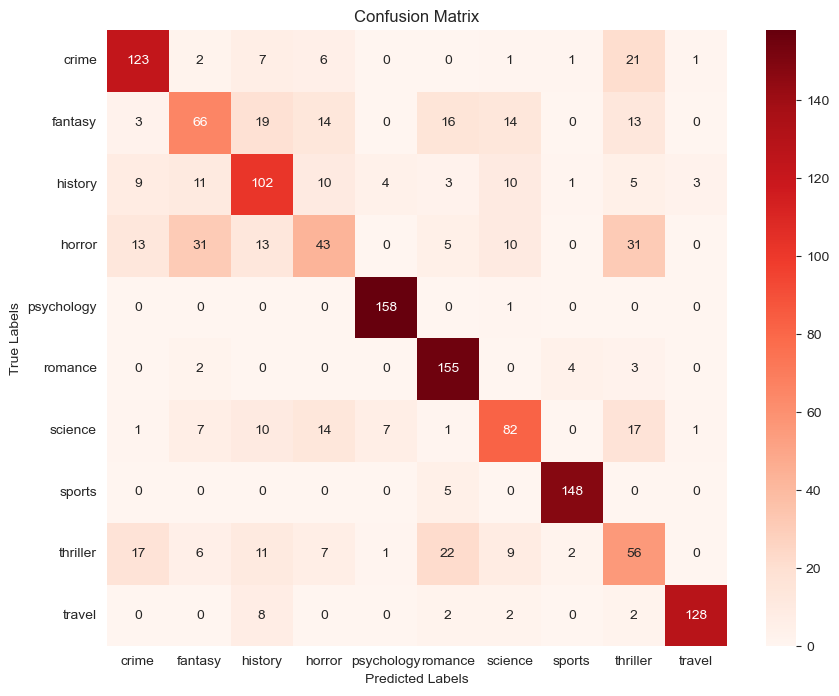

In [23]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=LE.classes_, yticklabels=LE.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Classification Report


In [24]:
# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=LE.classes_))

47/47 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

       crime       0.74      0.76      0.75       162
     fantasy       0.53      0.46      0.49       145
     history       0.60      0.65      0.62       158
      horror       0.46      0.29      0.36       146
  psychology       0.93      0.99      0.96       159
     romance       0.74      0.95      0.83       164
     science       0.64      0.59      0.61       140
      sports       0.95      0.97      0.96       153
    thriller       0.38      0.43      0.40       131
      travel       0.96      0.90      0.93       142

    accuracy                           0.71      1500
   macro avg       0.69      0.70      0.69      1500
weighted avg       0.70      0.71      0.70      1500



# save trained model

In [26]:
model.save("skipgrammodel.h5")

C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
